In [1]:
import matplotlib.pyplot as pl
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import sys
from datetime import datetime

# Custom scripts.
sys.path.append('/home/bart/meteo/projects_git/observations/aws')
from read_aws import Read_aws

# Custom script with help functions.
import helpers as hlp

In [2]:
"""
Read LES results.
"""
path = '/home/scratch1/bart/microhh/papers/dust_mahrooz_dirk/v1/high-res/'

# Read column statistics of virtual BSNE.
ds1_les = xr.open_dataset(f'{path}/20220511/valthermond.column.00130.00297.nc')
ds2_les = xr.open_dataset(f'{path}/20220515/valthermond.column.00130.00297.nc')
ds3_les = xr.open_dataset(f'{path}/20220623/valthermond.column.00130.00297.nc')

# Calculate absolute wind speed and direction.
ds1_les['U'] = np.sqrt(ds1_les.u**2 + ds1_les.v**2)
ds2_les['U'] = np.sqrt(ds2_les.u**2 + ds2_les.v**2)
ds3_les['U'] = np.sqrt(ds3_les.u**2 + ds3_les.v**2)

ds1_les['D'] = (180 + 180/np.pi * np.arctan2(ds1_les.u, ds1_les.v))%360
ds2_les['D'] = (180 + 180/np.pi * np.arctan2(ds2_les.u, ds2_les.v))%360
ds3_les['D'] = (180 + 180/np.pi * np.arctan2(ds3_les.u, ds3_les.v))%360

In [3]:
"""
Read KNMI AWS observations.
"""
base = '/home/scratch1/bart/observations/KDP/windgegevens/1.0/'

start_date = datetime(2022, 5, 1)
end_date   = datetime(2022, 7, 1)

aws_tot = Read_aws(base, 'kis_tow', start_date, end_date)

Reading "kis_tow" for 2022-05-01 00:00:00-2022-07-01 00:00:00
- Reading 2022-05-01 00:00:00
- Reading 2022-06-01 00:00:00


In [4]:
"""
Wind speed from Excel sheets Dirk.
Column names are a bit weird in Pandas; Wspeed2 = min, Wspeed2.1 = mean, Wspeed2.2 = max, et cetera.
"""
ds1_obs = pd.read_excel('data/data_Valthermond_2.xlsx', sheet_name='11 May 2022', index_col=0, parse_dates=True, header=0, skiprows=[1,2])
ds2_obs = pd.read_excel('data/data_Valthermond_1.xlsx', sheet_name='wind 15 May 2022', index_col=0, parse_dates=True, header=0, skiprows=[1,2])
ds3_obs = pd.read_excel('data/data_Valthermond_1.xlsx', sheet_name='wind 23 June 2022', index_col=0, parse_dates=True, header=0, skiprows=[1,2])

# Drop the unnamed columns (height info, which isn't available in all Excel sheets).
def drop_unnamed(df):
    return df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

ds_1_obs = drop_unnamed(ds1_obs)
ds_2_obs = drop_unnamed(ds2_obs)
ds_3_obs = drop_unnamed(ds3_obs)

In [5]:
"""
Find nearby AWS stations.
"""
stations = aws_tot.search_nearby(6.93, 52.87, max_distance=50)

hgv = aws_tot.get_station('279_W_a')

Searching near lat=52.87, lon=6.93 within 50 km:
- 279_W_a (Hoogeveen) @ 27.51 km
- 280_W_23t (Eelde locatie 23t) @ 36.45 km
- 280_W_05t (Eelde locatie 05t) @ 36.53 km
- 286_W_a (Nieuw Beerta) @ 38.94 km


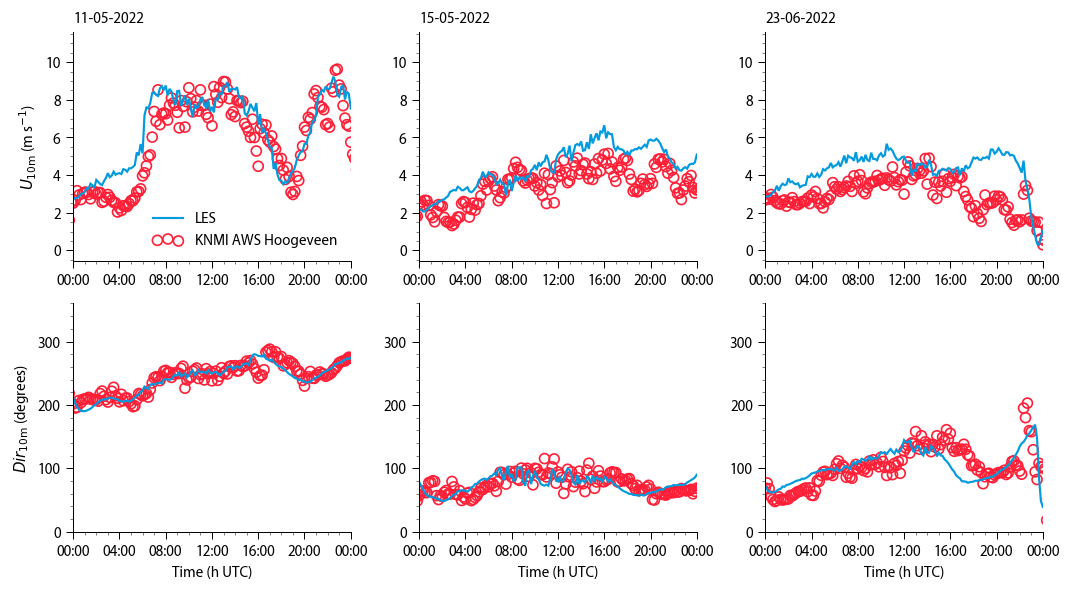

In [6]:
"""
Compare 10 m wind speed and direction with 10 m KNMI AWS at Hoogeveen (27.5 km distance...).
"""
lim_1 = (datetime(2022, 5, 11), datetime(2022, 5, 12))
lim_2 = (datetime(2022, 5, 15), datetime(2022, 5, 16))
lim_3 = (datetime(2022, 6, 23), datetime(2022, 6, 24))

# 10 minute mean of model data, like the observations, interpolated to 10 m height.
ds1_les_m = ds1_les.resample(time="10min").mean().interp(z=10, zh=10)
ds2_les_m = ds2_les.resample(time="10min").mean().interp(z=10, zh=10)
ds3_les_m = ds3_les.resample(time="10min").mean().interp(z=10, zh=10)

pl.figure(figsize=(9,5), layout='tight')

pl.subplot(231)
pl.title('11-05-2022', loc='left')
pl.plot(ds1_les_m.time, np.sqrt(ds1_les_m.u**2 + ds1_les_m.v**2), color='C2', label='LES')
pl.scatter(hgv.index, hgv.FF_10M_10, facecolor='none', edgecolor='C0', label='KNMI AWS Hoogeveen')
pl.xlim(lim_1)
pl.legend()
pl.ylabel(r'$U_\mathrm{10m}$ (m s$^{-1}$)')
hlp.fmt_ax(interval=4)

pl.subplot(232)
pl.title('15-05-2022', loc='left')
pl.plot(ds2_les_m.time, np.sqrt(ds2_les_m.u**2 + ds2_les_m.v**2), color='C2')
pl.scatter(hgv.index, hgv.FF_10M_10, facecolor='none', edgecolor='C0')
pl.xlim(lim_2)
hlp.fmt_ax(interval=4)

pl.subplot(233)
pl.title('23-06-2022', loc='left')
pl.plot(ds3_les_m.time, np.sqrt(ds3_les_m.u**2 + ds3_les_m.v**2), color='C2')
pl.scatter(hgv.index, hgv.FF_10M_10, facecolor='none', edgecolor='C0')
pl.xlim(lim_3)
hlp.fmt_ax(interval=4)

pl.subplot(234)
pl.plot(ds1_les_m.time, ds1_les_m.D, color='C2')
pl.scatter(hgv.index, hgv.DD_10, facecolor='none', edgecolor='C0')
pl.xlim(lim_1)
pl.ylim(0, 360)
pl.ylabel(r'$Dir_\mathrm{10m}$ (degrees)')
pl.xlabel('Time (h UTC)')
hlp.fmt_ax(interval=4)

pl.subplot(235)
pl.plot(ds2_les_m.time, ds2_les_m.D, color='C2')
pl.scatter(hgv.index, hgv.DD_10, facecolor='none', edgecolor='C0')
pl.xlim(lim_2)
pl.ylim(0, 360)
pl.xlabel('Time (h UTC)')
hlp.fmt_ax(interval=4)

pl.subplot(236)
pl.plot(ds3_les_m.time, ds3_les_m.D, color='C2')
pl.scatter(hgv.index, hgv.DD_10, facecolor='none', edgecolor='C0')
pl.xlim(lim_3)
pl.ylim(0, 360)
pl.xlabel('Time (h UTC)')
hlp.fmt_ax(interval=4)

In [7]:
"""
Statistics LES vs KNMI AWS.
"""
def calc_stats(ds_les, df_aws, label):
    """
    Colocate variables to same time series, and calculate some basic stats.
    """
    col_u = hlp.colocate(ds_les.time, ds_les.U, 'LES', df_aws.index, df_aws.FF_10M_10, 'obs')
    col_d = hlp.colocate(ds_les.time, ds_les.D, 'LES', df_aws.index, df_aws.DD_10, 'obs')
    
    u_bias = hlp.bias(col_u.LES, col_u.obs)
    d_bias = hlp.bias(col_d.LES, col_d.obs)

    u_rmse = hlp.rmse(col_u.LES, col_u.obs)
    d_rmse = hlp.rmse(col_d.LES, col_d.obs)

    print(f'{label}: bias U={u_bias:.1f} m/s, RMSE U={u_rmse:1f} m/s, bias Dir={d_bias:.1f} degree, RMSE Dir={d_rmse:.1f}.')

calc_stats(ds1_les_m, hgv, '11-05-2022')
calc_stats(ds2_les_m, hgv, '15-05-2022')
calc_stats(ds3_les_m, hgv, '23-06-2022')

11-05-2022: bias U=0.7 m/s, RMSE U=1.222364 m/s, bias Dir=-1.7 degree, RMSE Dir=11.0.
15-05-2022: bias U=1.0 m/s, RMSE U=1.229638 m/s, bias Dir=-0.4 degree, RMSE Dir=13.8.
23-06-2022: bias U=1.3 m/s, RMSE U=1.606306 m/s, bias Dir=1.0 degree, RMSE Dir=24.6.


In [8]:
"""
Compare wind speed with near-surface observations Dirk.
"""

lim_1 = (datetime(2022, 5, 11), datetime(2022, 5, 12))
lim_2 = (datetime(2022, 5, 15), datetime(2022, 5, 16))
lim_3 = (datetime(2022, 6, 23), datetime(2022, 6, 24))

# Interpolate LES to observation heights.
z = np.array([76.5, 117.5, 157.5]) / 100.
ktot = z.size

ds1_les_z = ds1_les.interp(z=z, zh=z)
ds2_les_z = ds2_les.interp(z=z, zh=z)
ds3_les_z = ds3_les.interp(z=z, zh=z)

# 1 minute mean, like the observations (?).
ds1_les_mean = ds1_les_z.resample(time="1min").mean()
ds2_les_mean = ds2_les_z.resample(time="1min").mean()
ds3_les_mean = ds3_les_z.resample(time="1min").mean()

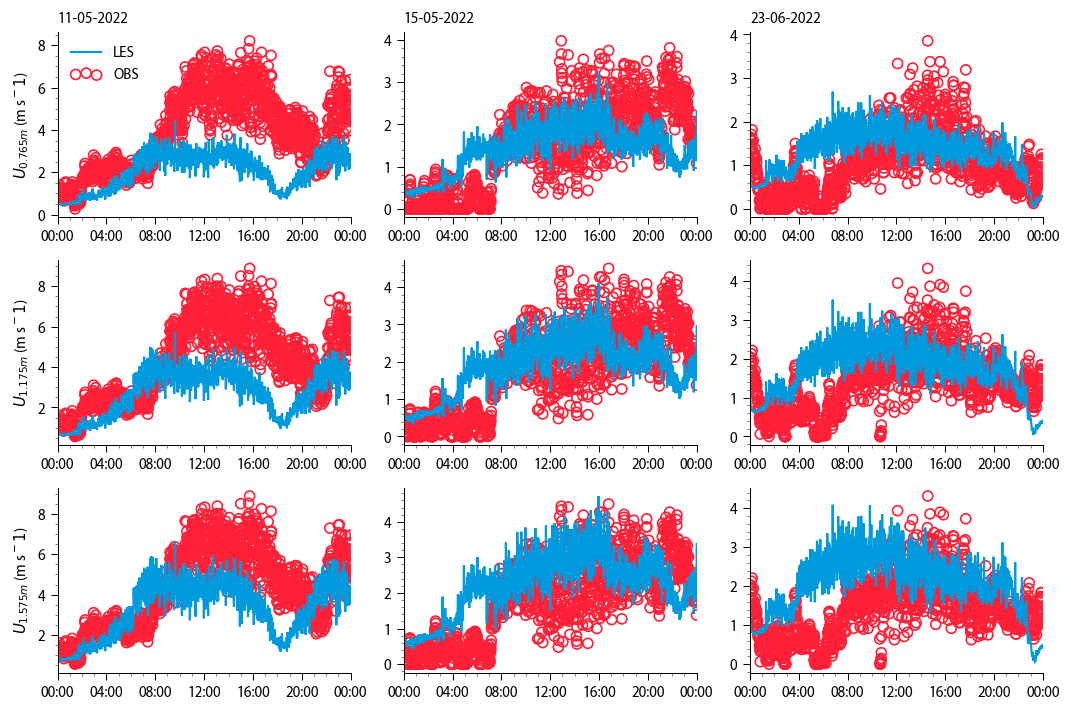

In [9]:
pl.figure(figsize=(9,6), layout='tight')

k = 0

pl.subplot(331)
pl.title('11-05-2022', loc='left')
pl.plot(ds1_les_mean.time, ds1_les_mean.U[:,k], color='C2', label=f'LES')
pl.scatter(ds1_obs.index, ds1_obs['WSpeed2.1'], facecolor='none', edgecolor='C0', label='OBS')
pl.xlim(lim_1)
pl.legend()
pl.ylabel(rf'$U_{{{z[k]}m}}$ (m s$^{-1}$)')
hlp.fmt_ax(interval=4)

pl.subplot(332)
pl.title('15-05-2022', loc='left')
pl.plot(ds2_les_mean.time, ds2_les_mean.U[:,k], color='C2')
pl.scatter(ds2_obs.index, ds2_obs['WSpeed2.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_2)
hlp.fmt_ax(interval=4)

pl.subplot(333)
pl.title('23-06-2022', loc='left')
pl.plot(ds3_les_mean.time, ds3_les_mean.U[:,k], color='C2')
pl.scatter(ds3_obs.index, ds3_obs['WSpeed2.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_3)
hlp.fmt_ax(interval=4)

k = 1

pl.subplot(334)
pl.plot(ds1_les_mean.time, ds1_les_mean.U[:,k], color='C2', label=f'LES')
pl.scatter(ds1_obs.index, ds1_obs['WSpeed3.1'], facecolor='none', edgecolor='C0', label='OBS')
pl.xlim(lim_1)
pl.ylabel(rf'$U_{{{z[k]}m}}$ (m s$^{-1}$)')
hlp.fmt_ax(interval=4)

pl.subplot(335)
pl.plot(ds2_les_mean.time, ds2_les_mean.U[:,k], color='C2')
pl.scatter(ds2_obs.index, ds2_obs['WSpeed3.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_2)
hlp.fmt_ax(interval=4)

pl.subplot(336)
pl.plot(ds3_les_mean.time, ds3_les_mean.U[:,k], color='C2')
pl.scatter(ds3_obs.index, ds3_obs['WSpeed3.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_3)
hlp.fmt_ax(interval=4)

k = 2

pl.subplot(337)
pl.plot(ds1_les_mean.time, ds1_les_mean.U[:,k], color='C2', label=f'LES')
pl.scatter(ds1_obs.index, ds1_obs['WSpeed3.1'], facecolor='none', edgecolor='C0', label='OBS')
pl.xlim(lim_1)
pl.ylabel(rf'$U_{{{z[k]}m}}$ (m s$^{-1}$)')
hlp.fmt_ax(interval=4)

pl.subplot(338)
pl.plot(ds2_les_mean.time, ds2_les_mean.U[:,k], color='C2')
pl.scatter(ds2_obs.index, ds2_obs['WSpeed3.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_2)
hlp.fmt_ax(interval=4)

pl.subplot(339)
pl.plot(ds3_les_mean.time, ds3_les_mean.U[:,k], color='C2')
pl.scatter(ds3_obs.index, ds3_obs['WSpeed3.1'], facecolor='none', edgecolor='C0')
pl.xlim(lim_3)
hlp.fmt_ax(interval=4)